# XGBoost for Regression in Tornasole
This notebook will demonstrate the simplest kind of interactive analysis that can be run in Tornasole. It will focus on the predicting the age of abalone ([Abalone dataset](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html)) using [XGBoost](https://github.com/dmlc/xgboost) for regression.

## Setup

Some basic setup that's always helpful

In [1]:
%load_ext autoreload
%autoreload 2

Make sure that you can run `xgboost`. You can install `xgboost` by doing
```shell
$ pip3 install xgboost
```
You'll probably have to restart this notebook after doing this.

Let's import some basic libraries for ML

In [2]:
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

Let's copy the Tornasole libraries to this instance, this step has to be executed only once. 
Please make sure that the AWS account you are using can access the `tornasole-external-preview-use1` bucket.

To do so you'll need the appropriate AWS credentials. There are several ways of doing this:
- inject temporary credentials 
- if running on EC2, use [EC2 roles](https://docs.aws.amazon.com/IAM/latest/UserGuide/id_roles_use_switch-role-ec2.html) that can access all S3 buckets
- (preferred) run this notebook on a [SageMaker notebook instance](https://docs.aws.amazon.com/sagemaker/latest/dg/nbi.html)

The code below downloads the necessary `.whl` files and installs them in the current environment. Only run the first time!


In [3]:
#WARNING - uncomment this code only if you haven't done this before
#!aws s3 sync s3://tornasole-external-preview-use1/sdk/ts-binaries/tornasole_xgboost/py3/latest/ tornasole_xgboost/
#!pip install tornasole_xgboost/tornasole-*

# If you run into a version conflict with boto, run the following
#!pip uninstall -y botocore boto3 aioboto3 aiobotocore && pip install botocore==1.12.91 boto3==1.9.91 aiobotocore==0.10.2 aioboto3==6.4.1

## Fetching the dataset

We use the [Abalone data](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html) originally from the [UCI data repository](https://archive.ics.uci.edu/ml/datasets/abalone). More details about the original dataset can be found [here](https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.names). In the libsvm converted [version](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression.html), the nominal feature (Male/Female/Infant) has been converted into a real valued feature. Age of abalone is to be predicted from eight physical measurements.

In [4]:
%%time
import random
import tempfile
import urllib.request


def load_abalone(train_split=0.8, seed=42):

    if not (0 < train_split <= 1):
        raise ValueError("'train_split' must be between 0 and 1.")

    url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/abalone"

    response = urllib.request.urlopen(url).read().decode("utf-8")
    lines = response.strip().split('\n')
    n = sum(1 for line in lines)
    indices = list(range(n))
    random.seed(seed)
    random.shuffle(indices)
    train_indices = set(indices[:int(n * 0.8)])

    with tempfile.NamedTemporaryFile(mode='w', delete=False) as train_file:
        with tempfile.NamedTemporaryFile(mode='w', delete=False) as valid_file:
            for idx, line in enumerate(lines):
                if idx in train_indices:
                    train_file.write(line + '\n')
                else:
                    valid_file.write(line + '\n')

    return train_file.name, valid_file.name

train_file, validation_file = load_abalone()

CPU times: user 28.5 ms, sys: 9.39 ms, total: 37.9 ms
Wall time: 6.01 s



## Model Training

At this point we have all the ingredients installed on our machine. We can now start training.

In [5]:
from tornasole import SaveConfig
from tornasole.xgboost import TornasoleHook
from tornasole.trials import LocalTrial

We can change the logging level if appropriate 

In [6]:
#import logging
#logging.getLogger("tornasole").setLevel(logging.WARNING)

Clean up from previous runs, we remove old data (warning - we assume that we have set `ts_output` as the directory into which we send data)

In [7]:
!rm -rf ./ts_output/

We load the datasets into [DMatrix](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.DMatrix) objects and define some hyperparameters - it doesn't really matter what it is.

In [8]:
dtrain = xgb.DMatrix(train_file)
dval = xgb.DMatrix(validation_file)

watchlist = [(dtrain, 'train'), (dval, 'validation')]

params = {
    "max_depth": 5,
    "eta": 0.2,
    "gamma": 4,
    "min_child_weight": 6,
    "subsample": 0.7,
    "silent": 0,
    "objective": "reg:squarederror",
    "eval_metric": ["rmse", "mae"]
}

num_round = 100

[20:28:55] 3341x9 matrix with 26728 entries loaded from /var/folders/8f/_jkz_jm54y56k334j6vkhlr51s_6bx/T/tmps8ervlbn
[20:28:55] 836x9 matrix with 6688 entries loaded from /var/folders/8f/_jkz_jm54y56k334j6vkhlr51s_6bx/T/tmprvihe8rx


Importantly - we **add the Tornasole Hook**. This hook will be run at every iteration and will save selected performance metrics, feature importances, or [SHAP](https://github.com/slundberg/shap) values (in this case, all of them) to the desired directory (in this case, `'{base_loc}/{run_id}'`.

`{base_loc}` can be either a path on a local file system (for instance, `./ts_output/`) or an S3 bucket/object (`s3://mybucket/myprefix/`).

See the documentation for more details.

In [9]:
save_config = SaveConfig(save_interval=5)

tornasole_hook = TornasoleHook(
    out_dir="./ts_output",
    save_config=save_config,
    shap_data=dtrain
)

[2019-09-04 20:28:55.303 38f9d36a2c42.ant.amazon.com:42958 INFO hook.py:86] Saving to ./ts_output


At this point we are ready to train. We will train this simple model.

Behind the scenes, the `TornasoleHook` is saving the data requested.

In [10]:
bst = xgb.train(
    params=params,
    dtrain=dtrain,
    evals=watchlist,
    num_boost_round=num_round,
    callbacks=[tornasole_hook])

[2019-09-04 20:28:55.359 38f9d36a2c42.ant.amazon.com:42958 INFO hook.py:182] Saved iteration 0.
[0]	train-rmse:8.12809	train-mae:7.57979	validation-rmse:7.9501	validation-mae:7.42376
[1]	train-rmse:6.66075	train-mae:6.0853	validation-rmse:6.50774	validation-mae:5.95214
[2]	train-rmse:5.49178	train-mae:4.87746	validation-rmse:5.35986	validation-mae:4.76687
[3]	train-rmse:4.58214	train-mae:3.91531	validation-rmse:4.47214	validation-mae:3.81942
[4]	train-rmse:3.87782	train-mae:3.14893	validation-rmse:3.79344	validation-mae:3.07788
[2019-09-04 20:28:55.438 38f9d36a2c42.ant.amazon.com:42958 INFO hook.py:182] Saved iteration 5.
[5]	train-rmse:3.35051	train-mae:2.57049	validation-rmse:3.28752	validation-mae:2.51613
[6]	train-rmse:2.95214	train-mae:2.14503	validation-rmse:2.91198	validation-mae:2.11696
[7]	train-rmse:2.66585	train-mae:1.85231	validation-rmse:2.63266	validation-mae:1.83957
[8]	train-rmse:2.45031	train-mae:1.65847	validation-rmse:2.45043	validation-mae:1.6836
[9]	train-rmse:2.29

[76]	train-rmse:1.53418	train-mae:1.12846	validation-rmse:2.07262	validation-mae:1.47965
[77]	train-rmse:1.52683	train-mae:1.12359	validation-rmse:2.07258	validation-mae:1.47693
[78]	train-rmse:1.52175	train-mae:1.12025	validation-rmse:2.0736	validation-mae:1.47748
[79]	train-rmse:1.51673	train-mae:1.11775	validation-rmse:2.07555	validation-mae:1.47927
[2019-09-04 20:29:01.110 38f9d36a2c42.ant.amazon.com:42958 INFO hook.py:182] Saved iteration 80.
[80]	train-rmse:1.51552	train-mae:1.11628	validation-rmse:2.07579	validation-mae:1.47937
[81]	train-rmse:1.51042	train-mae:1.11335	validation-rmse:2.07407	validation-mae:1.47882
[82]	train-rmse:1.49888	train-mae:1.10658	validation-rmse:2.07054	validation-mae:1.47881
[83]	train-rmse:1.48993	train-mae:1.10055	validation-rmse:2.07382	validation-mae:1.48155
[84]	train-rmse:1.48741	train-mae:1.09893	validation-rmse:2.07477	validation-mae:1.48274
[2019-09-04 20:29:01.640 38f9d36a2c42.ant.amazon.com:42958 INFO hook.py:182] Saved iteration 85.
[85]	t

## Data Analysis - Manual
Now that we have trained the system we can analyze the data. Notice that this notebook focuses on after-the-fact analysis. Tornasole also provides a collection of tools to do automatic analysis as the training run is progressing, which will be covered in a different notebook.

We import a basic analysis library, which defines a concept of `Trial`. A `Trial` is a single training run, which is depositing values in a local directory (`LocalTrial`) or S3 (`S3Trial`). In this case we are using a `LocalTrial` - if you wish, you can change the output from `./ts_output` to `s3://mybucket/myprefix` and use `S3Trial` instead of `LocalTrial`.

And we read the data

In [11]:
trial = LocalTrial("myrun", "./ts_output")

[2019-09-04 20:29:03.117 38f9d36a2c42.ant.amazon.com:42958 INFO local_trial.py:22] Loading trial myrun at path ./ts_output
[2019-09-04 20:29:03.119 38f9d36a2c42.ant.amazon.com:42958 INFO local_trial.py:58] Loaded 3 collections


We can list all the tensors we know something about. Each one of these names is the name of a tensor - the name is a combination of the feature name (which, in these cases, is auto-assigned by XGBoost) and whether it's an evaluation metric, feature importance, or SHAP value.

In [12]:
trial.tensors()

[2019-09-04 20:29:06.817 38f9d36a2c42.ant.amazon.com:42958 INFO trial.py:98] Training has ended, will try to do a final refresh in 5 sec
[2019-09-04 20:29:11.839 38f9d36a2c42.ant.amazon.com:42958 INFO trial.py:103] Marked loaded all steps to True


['train-rmse',
 'train-mae',
 'validation-rmse',
 'validation-mae',
 'f8/feature_importance',
 'f2/feature_importance',
 'f6/feature_importance',
 'f1/feature_importance',
 'f4/feature_importance',
 'f1/average_shap',
 'f2/average_shap',
 'f4/average_shap',
 'f6/average_shap',
 'f3/feature_importance',
 'f5/feature_importance',
 'f7/feature_importance',
 'f3/average_shap',
 'f7/average_shap',
 'f5/average_shap']

For each tensor we can ask for which steps we have data - in this case, every 5 steps

In [13]:
trial.tensor("f8/feature_importance").steps()

[0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]

We can obtain each tensor at each step as a `numpy` array

In [14]:
type(trial.tensor("f8/feature_importance").step(30).value)

numpy.ndarray

### Performance metrics

We can also create a simple function that visualizes the training and validation errors
as the training progresses.
We expect each gradient to get smaller over time, as the system converges to a good solution.
Now, remember that this is an interactive analysis - we are showing these tensors to give an idea of the data. 

Later on in this notebook we will run an automated analysis.

In [15]:
# Define a function that, for the given tensor name, walks through all 
# the iterations for which we have data and fetches the value.
# Returns the set of steps and the values

def get_data(trial, tname):
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals

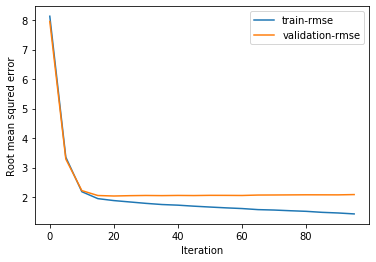

In [16]:
metrics_to_plot = ["train-rmse", "validation-rmse"]
for metric in metrics_to_plot:
    steps, data = get_data(trial, metric)
    plt.plot(steps, data, label=metric)
plt.xlabel('Iteration')
plt.ylabel('Root mean squred error')
plt.legend()
plt.show()

### Feature importances

We can also visualize the feature importances as determined by
[xgboost.get_fscore()](https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.Booster.get_fscore).
Note that feature importances with zero values are not included here
(which means that those features were not used in any split condisitons).

In [17]:
def plot_collections(trial, endswith, ylabel=''):
    
    plt.figure(
        num=1, figsize=(8, 8), dpi=80,
        facecolor='w', edgecolor='k')

    features_to_plot = [
        tname for tname in trial.tensors()
        if tname.endswith(endswith)
    ]

    for feature in sorted(features_to_plot):
        steps, data = get_data(trial, feature)
        label = feature.replace(endswith, '')
        plt.plot(steps, data, label=label)

    plt.legend(bbox_to_anchor=(1.04,1), loc='upper left')
    plt.xlabel('Iteration')
    plt.ylabel(ylabel)
    plt.show()

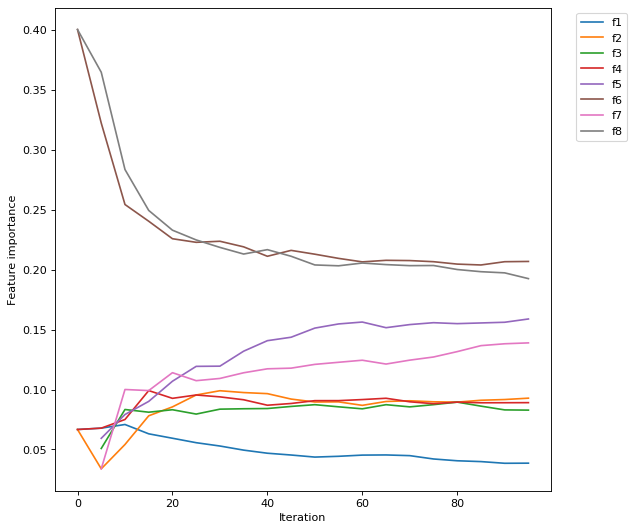

In [18]:
plot_collections(trial, "/feature_importance", "Feature importance")

### SHAP

[SHAP](https://github.com/slundberg/shap) (SHapley Additive exPlanations) is
another approach to explain the output of machine learning models.
SHAP values represent a feature's contribution to a change in the model output.

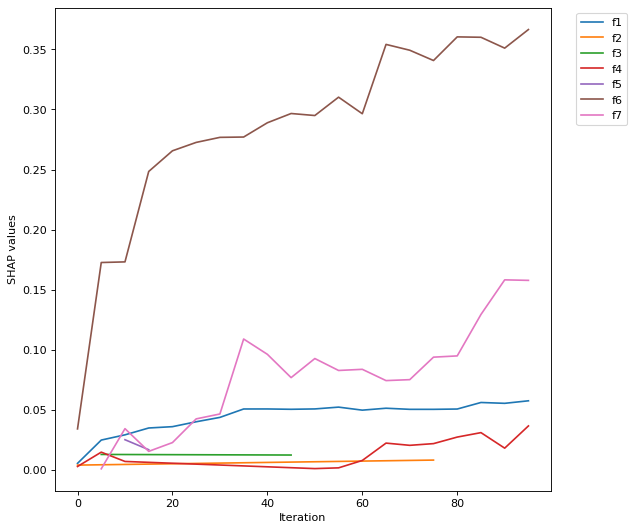

In [19]:
plot_collections(trial, "/average_shap", "SHAP values")

## Data Analysis - Automatic
So far we have conducted a human analysis, but the real power of Tornasole comes from having automatic monitoring of training runs. To do so we will build a SageMaker-based system that monitors existing runs in real time. Data traces deposited in S3 are the exchange mechanism: 
- the training system deposits data into s3://mybucket/myrun/
- the monitoring system watches and reads data from s3://mybucket/myrun/

In this example we will simulate reading from that.

In [20]:
from tornasole.rules.generic import LossNotDecreasing
from tornasole.rules.rule_invoker import invoke_rule

In [21]:
loss_not_decreasing = LossNotDecreasing(
    trial,
    use_losses_collection=False,
    collection_names="metric",
    num_steps=5)
invoke_rule(loss_not_decreasing, end_step=95)

[2019-09-04 20:29:13.371 38f9d36a2c42.ant.amazon.com:42958 INFO loss_decrease.py:65] LossNotDecreasing rule created with num_steps: 5, diff_percent: 0.0, mode: GLOBAL, tensor_regex: , collection_names: metric
[2019-09-04 20:29:13.372 38f9d36a2c42.ant.amazon.com:42958 INFO rule_invoker.py:76] Started execution of rule LossNotDecreasing at step 0
[2019-09-04 20:29:13.376 38f9d36a2c42.ant.amazon.com:42958 INFO loss_decrease.py:180] 1 loss is not decreasing over the last 5 steps at step 20
[2019-09-04 20:29:13.377 38f9d36a2c42.ant.amazon.com:42958 INFO loss_decrease.py:180] 2 losses are  not decreasing over the last 5 steps at step 25
[2019-09-04 20:29:13.380 38f9d36a2c42.ant.amazon.com:42958 INFO loss_decrease.py:180] 2 losses are  not decreasing over the last 5 steps at step 30
[2019-09-04 20:29:13.382 38f9d36a2c42.ant.amazon.com:42958 INFO loss_decrease.py:180] 1 loss is not decreasing over the last 5 steps at step 35
[2019-09-04 20:29:13.384 38f9d36a2c42.ant.amazon.com:42958 INFO loss_

This concludes this notebook. For more information see the documentation at  
- https://github.com/awslabs/tornasole_core
